# ALS BL5.3.1 beamstop scan using bluesky

awojdyla@lbl.gov tjferron@lbl.gov - April 2025

We want to perform an automated scan of the beamstop

In [1]:
import epics
import bluesky
#import numpy
#import matplotlib.pyplot as plt
#import time 

In [2]:
from bluesky import RunEngine
RE = RunEngine({})

In [3]:
from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

0

### Connecting to EPICS motors
We had some issues here witht the picoscale interformeter -- we need to use caproto to talk to it (ophyd's motor does not work directly out of the box)

from: https://nsls-ii.github.io/bluesky/tutorial.html

```
from ophyd import EpicsMotor
nano_top_x = EpicsMotor('XF:31ID-ES{Dif:Nano-Ax:TopX}Mtr', name='nano_top_x')
```
see also:

https://blueskyproject.io/ophyd/generated/ophyd.epics_motor.EpicsMotor.html#:~:text=class%20ophyd.epics_motor.EpicsMotor%28prefix%3D%27%27%2C%20%2A%2C%20name%2C%20kind%3DNone%2C%20read_attrs%3DNone%2C%20configuration_attrs%3DNone%2C%20parent%3DNone%2C,are%20passed%20through%20to%20the%20base%20class%2C%20Positioner




In [4]:
from ophyd import EpicsMotor
import ophyd
ophyd.set_cl('caproto')

sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

beamstop_x_mm = ophyd.EpicsMotor('bl531_xps2:beamstop_x_mm', name='beamstop horizontal')
beamstop_y_mm = ophyd.EpicsMotor('bl531_xps2:beamstop_y_mm', name='beamstop vertical')

beamstop_diode = ophyd.EpicsSignal('bl201-beamstop:current', name='beamstop diode')

#this works
sample_x_mm.wait_for_connection(timeout=2.0)
sample_x_mm.read()
sample_y_mm.wait_for_connection(timeout=2.0)
sample_y_mm.read()
beamstop_diode.wait_for_connection(timeout=2.0)
beamstop_diode.read()

{'beamstop diode': {'value': -879.0, 'timestamp': 1745084548.345625}}

In [ ]:
## this has crashed my motors -- be careful

# # some issues here -- not critical
# from bluesky.callbacks.best_effort import BestEffortCallback
# bec = BestEffortCallback()
# # Send all metadata/data captured to the BestEffortCallback.
# bec_token = RE.subscribe(bec)

#RE.unsubscribe(bec_token)

In [9]:
from bluesky.plans import grid_scan

#RE(grid_scan([beamstop_diode], sample_x_mm, 1, 2, 3, sample_y_mm, 1,2,3))
RE(grid_scan([beamstop_diode], beamstop_x_mm, 0, 20, 11, beamstop_y_mm, 0,20,11))

('29ad8784-ace7-4fc6-8795-66ed6c8b54a3',)

In [10]:
header = db[-1]
header.table()

,time,beamstop diode,beamstop vertical,beamstop vertical_user_setpoint,beamstop horizontal,beamstop horizontal_user_setpoint
seq_num,,,,,,
1,2025-04-19 16:52:16.717237473,-0.9516,0.0,0.0,0.0,0.0
2,2025-04-19 16:52:19.790462971,-0.9875,2.0,2.0,0.0,0.0
3,2025-04-19 16:52:22.872891426,-0.9640,4.0,4.0,0.0,0.0
4,2025-04-19 16:52:25.956268072,-0.9559,6.0,6.0,0.0,0.0
5,2025-04-19 16:52:29.035397530,-1.0036,8.0,8.0,0.0,0.0
...,...,...,...,...,...,...
117,2025-04-19 17:01:14.475955248,-1.2417,12.0,12.0,20.0,20.0
118,2025-04-19 17:01:17.555122137,-1.2601,14.0,14.0,20.0,20.0
119,2025-04-19 17:01:20.627711296,-1.2614,16.0,16.0,20.0,20.0


In [12]:
a = header.table()

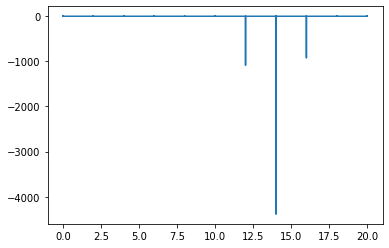

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

h = a['beamstop horizontal'].to_numpy()
v = a['beamstop vertical'].to_numpy()
v = a['beamstop diode'].to_numpy()

plt.plot(h, v)
plt.show()

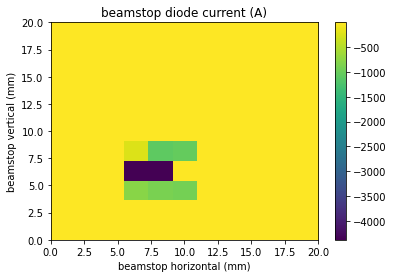

Server at 192.168.10.123:36109 is unresponsive. Disconnecting circuit manager <VirtualCircuitManager circuit=<VirtualCircuit host='192.168.10.123' port=36109 our_role=Role.CLIENT> logger_name='caproto.circ'> pvs=76 ioids=0 subscriptions=64>. PVs will automatically begin attempting to reconnect to a responsive server.
Server at 192.168.10.123:46063 is unresponsive. Disconnecting circuit manager <VirtualCircuitManager circuit=<VirtualCircuit host='192.168.10.123' port=46063 our_role=Role.CLIENT> logger_name='caproto.circ'> pvs=1 ioids=0 subscriptions=0>. PVs will automatically begin attempting to reconnect to a responsive server.


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['beamstop horizontal'].to_numpy()
v = a['beamstop vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(11, 11)

plt.imshow(b, extent=(h.min(), h.max(), v.min(), v.max()), aspect='auto')
plt.xlabel('beamstop horizontal (mm)')
plt.ylabel('beamstop vertical (mm)')
plt.title('beamstop diode current (A)')
plt.colorbar()
plt.show()

In [6]:
from tqdm import tqdm
from bluesky.plans import grid_scan

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 11, sample_y_mm, 0,20,11,snake_axes=True))


('56cb5c39-284c-4719-a899-4f8ee30fa4a8',)

In [7]:
header = db[-1]
a = header.table()

a

,time,sample stage vertical,sample stage vertical_user_setpoint,sample stage horizontal,sample stage horizontal_user_setpoint,beamstop diode
seq_num,,,,,,
1,2025-04-19 17:43:30.434571505,0.0,0.0,0.0,0.0,-4034.0000
2,2025-04-19 17:43:33.511249065,2.0,2.0,0.0,0.0,-859.2000
3,2025-04-19 17:43:36.580780983,4.0,4.0,0.0,0.0,-879.1000
4,2025-04-19 17:43:39.665604353,6.0,6.0,0.0,0.0,-902.2000
5,2025-04-19 17:43:42.735484123,8.0,8.0,0.0,0.0,-886.9000
...,...,...,...,...,...,...
117,2025-04-19 17:49:27.307336807,12.0,12.0,20.0,20.0,-3842.0000
118,2025-04-19 17:49:30.387142658,14.0,14.0,20.0,20.0,-3844.0000
119,2025-04-19 17:49:33.469036341,16.0,16.0,20.0,20.0,-3875.0000


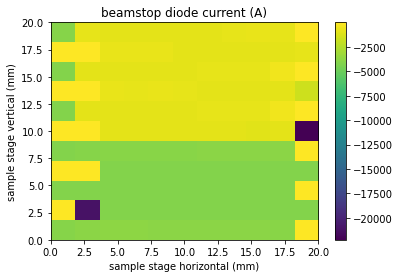

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(11, 11)

plt.imshow(b, extent=(h.min(), h.max(), v.min(), v.max()), aspect='auto')
plt.xlabel('sample stage horizontal (mm)')
plt.ylabel('sample stage vertical (mm)')
plt.title('beamstop diode current (A)')
plt.colorbar()
plt.show()

In [ ]:
RE(scan(dets, motors, 25, 28, 61))

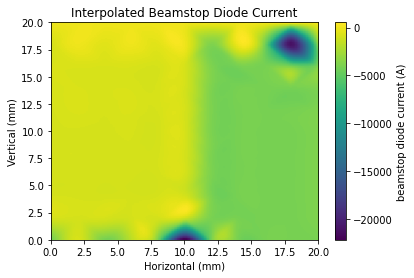

In [10]:
from scipy.interpolate import griddata
import numpy as np

# Define the grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(h.min(), h.max(), 100),  # 100 points along the horizontal axis
    np.linspace(v.min(), v.max(), 100)  # 100 points along the vertical axis
)

# Interpolate the data
grid_z = griddata(
    points=(h, v),  # Original data points
    values=b.flatten(),  # Values at those points
    xi=(grid_x, grid_y),  # Grid to interpolate onto
    method='cubic'  # Interpolation method: 'linear', 'nearest', or 'cubic'
)

# Plot the interpolated data
plt.imshow(
    grid_z, extent=(h.min(), h.max(), v.min(), v.max()), origin='lower', aspect='auto'
)
plt.colorbar(label='beamstop diode current (A)')
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title('Interpolated Beamstop Diode Current')
plt.show()

In [ ]:
epics.caput('DMC02:E.CNEN', 0)
epics.caput('DMC02:F.CNEN', 0)
epics.caput('DMC02:G.CNEN', 0)
epics.caput('DMC02:H.CNEN', 0)

1

Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverity.MAJOR
Motion failed: sample stage vertical is in an alarm state status=AlarmStatus.STATE severity=AlarmSeverit

In [27]:
epics.caget('DMC02:F')


0.0

In [31]:
epics.caput('DMC02:F', 300)

1